### Imports

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Values:
# 0 = all logs (default)
# 1 = filter out INFO
# 2 = filter out INFO and WARNING

import joblib, json, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing as fs
from scripts import utils
from scripts.models import get_model_specs
from scripts.model_runner import run_models
from scripts.metric import compute_row, aggregate
from scripts.plotting import metric_grid, metric_box

# Directories
RES_DIR = Path("results"); RES_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
CACHE = RES_DIR / "model_cache"; CACHE.mkdir(exist_ok=True)

2025-07-31 13:49:12.681399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 13:49:12.681438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 13:49:12.682366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Experiment Grid

In [2]:
WINDOW_SIZES = [3, 5, 7, 10, 15, 30, 60] # seconds
MODEL_SPECS = get_model_specs() # all models
# SEEDS = np.random.RandomState(14).choice(
# 	np.arange(10), size=3, replace=False).tolist()
SEEDS = [0, 1, 2] # for reproducibility
CV_FOLDS = 5
WINDOW_FREQ = 100 #Hz
print(f"Random seeds: {SEEDS}")

Random seeds: [0, 1, 2]


### Train/Test Subject Split
To avoid data leakage, we separate some subjects for final testing and use the training set only for cross-validation.

In [3]:
# Load train and test data if available, otherwise compute
try:
	subjects = json.load((open(RES_DIR/"subjects.json", "r")))
	TRAIN_SUBJ = subjects['train']
	TEST_SUBJ = subjects['test']
	print("Loaded train/test subjects from subjects.json")
except FileNotFoundError:
	print("No subjects.json found, computing train/test split...")
	TRAIN_SUBJ, TEST_SUBJ = utils.train_test_subjects_split(
		fs, test_size=0.2, random_state=42)
	json.dump({"train": TRAIN_SUBJ.tolist(), "test": TEST_SUBJ.tolist()},
			  open(RES_DIR/"subjects.json", "w"))

Loaded train/test subjects from subjects.json


### Initial Cross-validation and Window Size Selection

In [4]:
train_df = fs.load().query("SubjectID in @TRAIN_SUBJ")

In [7]:
from scripts.cv_runner import CVRunner

dummy_specs = get_model_specs(kind="baseline")
DUMMY_CV_ROWS = []
kwargs = dict(
	multiphase=True,
	segment_test=False,
	thresh=1.4
)
run_kwargs = dict(
	verbose=True,
    model_specs=dummy_specs,
    ensemble_models=True,         
    ensemble_by_kind=True                  
)

Baseline models

In [ ]:
for win in WINDOW_SIZES:
	print(f"Running CV for window size {win} seconds")
	runner = CVRunner(
        df=train_df,
        dataset=fs,
        groups="SubjectID",
        split_df_fn=utils.split_df,
        run_models_fn=run_models,
        window_size=win,
        cv=CV_FOLDS,
        kwargs=kwargs
    )
	dummy_fold_df = runner.run(**run_kwargs)
	dummy_fold_df["window_size"] = win
	DUMMY_CV_ROWS.append(dummy_fold_df)
dummy_cv_metrics = pd.concat(DUMMY_CV_ROWS, ignore_index=True)
dummy_cv_metrics.to_csv(RES_DIR / "dummy_cv_all_windows.csv", index=False)

Running CV for window size 3 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1080, 300), y: (1080,)    ([ADLs, Falls]) [978 102]
Test set: X: 22, y: 22
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTING DummyADL_0. DummyFall_0. ✅

– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1140, 300), y: (1140,)    ([ADLs, Falls]) [1053   87]
Test set: X: 37, y: 37
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTING DummyADL_0. DummyFall_0. ✅

– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (969, 300), y: (969,)    ([ADLs, Falls]) [856 113]
Test set: X: 11, y: 11
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTING DummyADL_0. DummyFall_0. ✅

– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1182, 300), y: (1182,)    ([ADLs, Falls]) [1074  108]
Test set: X: 16, y: 16
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTI

Real models

In [ ]:
ALL_CV_ROWS = []
run_kwargs.update(model_specs=MODEL_SPECS)
models = [spec for spec in MODEL_SPECS\
		  if spec.kind != "baseline"]
for win in WINDOW_SIZES:
	print(f"Running CV for window size {win} seconds")
	runner = CVRunner(
        df=train_df,
        dataset=fs,
        groups="SubjectID",
        split_df_fn=utils.split_df,
        run_models_fn=run_models,
        window_size=win,
        cv=CV_FOLDS,
        kwargs=kwargs
    )
	fold_df = runner.run(**run_kwargs)
	fold_df["window_size"] = win
	ALL_CV_ROWS.append(fold_df)
cv_metrics = pd.concat(ALL_CV_ROWS, ignore_index=True)
cv_metrics.to_csv(RES_DIR / "cv_all_windows_new.csv", index=False)

Running CV for window size 3 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1080, 300), y: (1080,)    ([ADLs, Falls]) [978 102]
Test set: X: 22, y: 22
TRAINING (seed=0) ExtraTrees. MiniRocket. Catch22. QUANT. ResNet

I0000 00:00:1753969846.866369 3218112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


. ✅
19/19 [==============================] - 0s 2ms/step
✅

– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1140, 300), y: (1140,)    ([ADLs, Falls]) [1053   87]
Test set: X: 37, y: 37
TRAINING (seed=0) ExtraTrees. MiniRocket. Catch22. QUANT. ResNet. ✅
19/19 [==============================] - 0s 2ms/step
✅

– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (969, 300), y: (969,)    ([ADLs, Falls]) [856 113]
Test set: X: 11, y: 11
TRAINING (seed=0) ExtraTrees. MiniRocket. Catch22. QUANT. ResNet. ✅
19/19 [==============================] - 0s 2ms/step
✅

– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1182, 300), y: (1182,)    ([ADLs, Falls]) [1074  108]
Test set: X: 16, y: 16
TRAINING (seed=0) ExtraTrees. MiniRocket. Catch22. QUANT. ResNet. ✅
19/19 [==============================] - 0s 2ms/step
✅

– Fold 5/5: testing on 6 subjects –
Train set: 86 samp

In [5]:
real_cv_metrics = pd.read_csv(RES_DIR / "cv_all_windows.csv")
dummy_cv_metrics = pd.read_csv(RES_DIR / "dummy_cv_all_windows.csv")
all_cv_metrics = pd.concat([real_cv_metrics, dummy_cv_metrics], ignore_index=True)
all_cv_metrics

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,fold,thresh
0,LogisticCV,0.0,3,0.205031,4.454545,0.842105,0.727273,0.999999,0.780488,0.863636,0.409088,0.818175,0.001000,1,NaN
1,RandomForest,0.0,3,0.198551,0.045455,0.800000,0.909091,0.999998,0.851064,0.954545,0.681813,0.272725,0.001000,1,NaN
2,ExtraTrees,0.0,3,0.200628,0.909091,0.909091,0.909091,0.999999,0.909091,0.954545,0.272725,0.272725,0.001000,1,NaN
3,Rocket,0.0,3,4.023338,0.545455,0.333333,0.818182,0.999986,0.473684,0.909084,4.909050,0.545450,0.001000,1,NaN
4,Catch22,0.0,3,6.329436,0.772727,0.714286,0.909091,0.999997,0.800000,0.954544,1.090900,0.272725,0.001000,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,DummyFall,0.0,60,0.000361,0.000000,0.000500,1.000000,0.000000,0.001000,0.500000,5996.950025,0.000000,-0.005323,3,0.5
381,DummyADL,0.0,60,0.086385,20.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,2.999975,4.997504,4,0.5
382,DummyFall,0.0,60,0.000376,0.000000,0.000500,1.000000,0.000000,0.001000,0.500000,5996.950025,0.000000,-0.008872,4,0.5
383,DummyADL,0.0,60,0.091053,20.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,3.016140,12.261073,5,0.5


In [6]:
best_rows = (
    all_cv_metrics
    .groupby(["model", "window_size"])
    ["f1-score"].mean()
    .unstack("window_size")
    .idxmax(axis=1) # window with highest mean F1
)
BEST_WINDOW = best_rows.to_dict()
json.dump(BEST_WINDOW, open(RES_DIR/"best_window.json","w"))

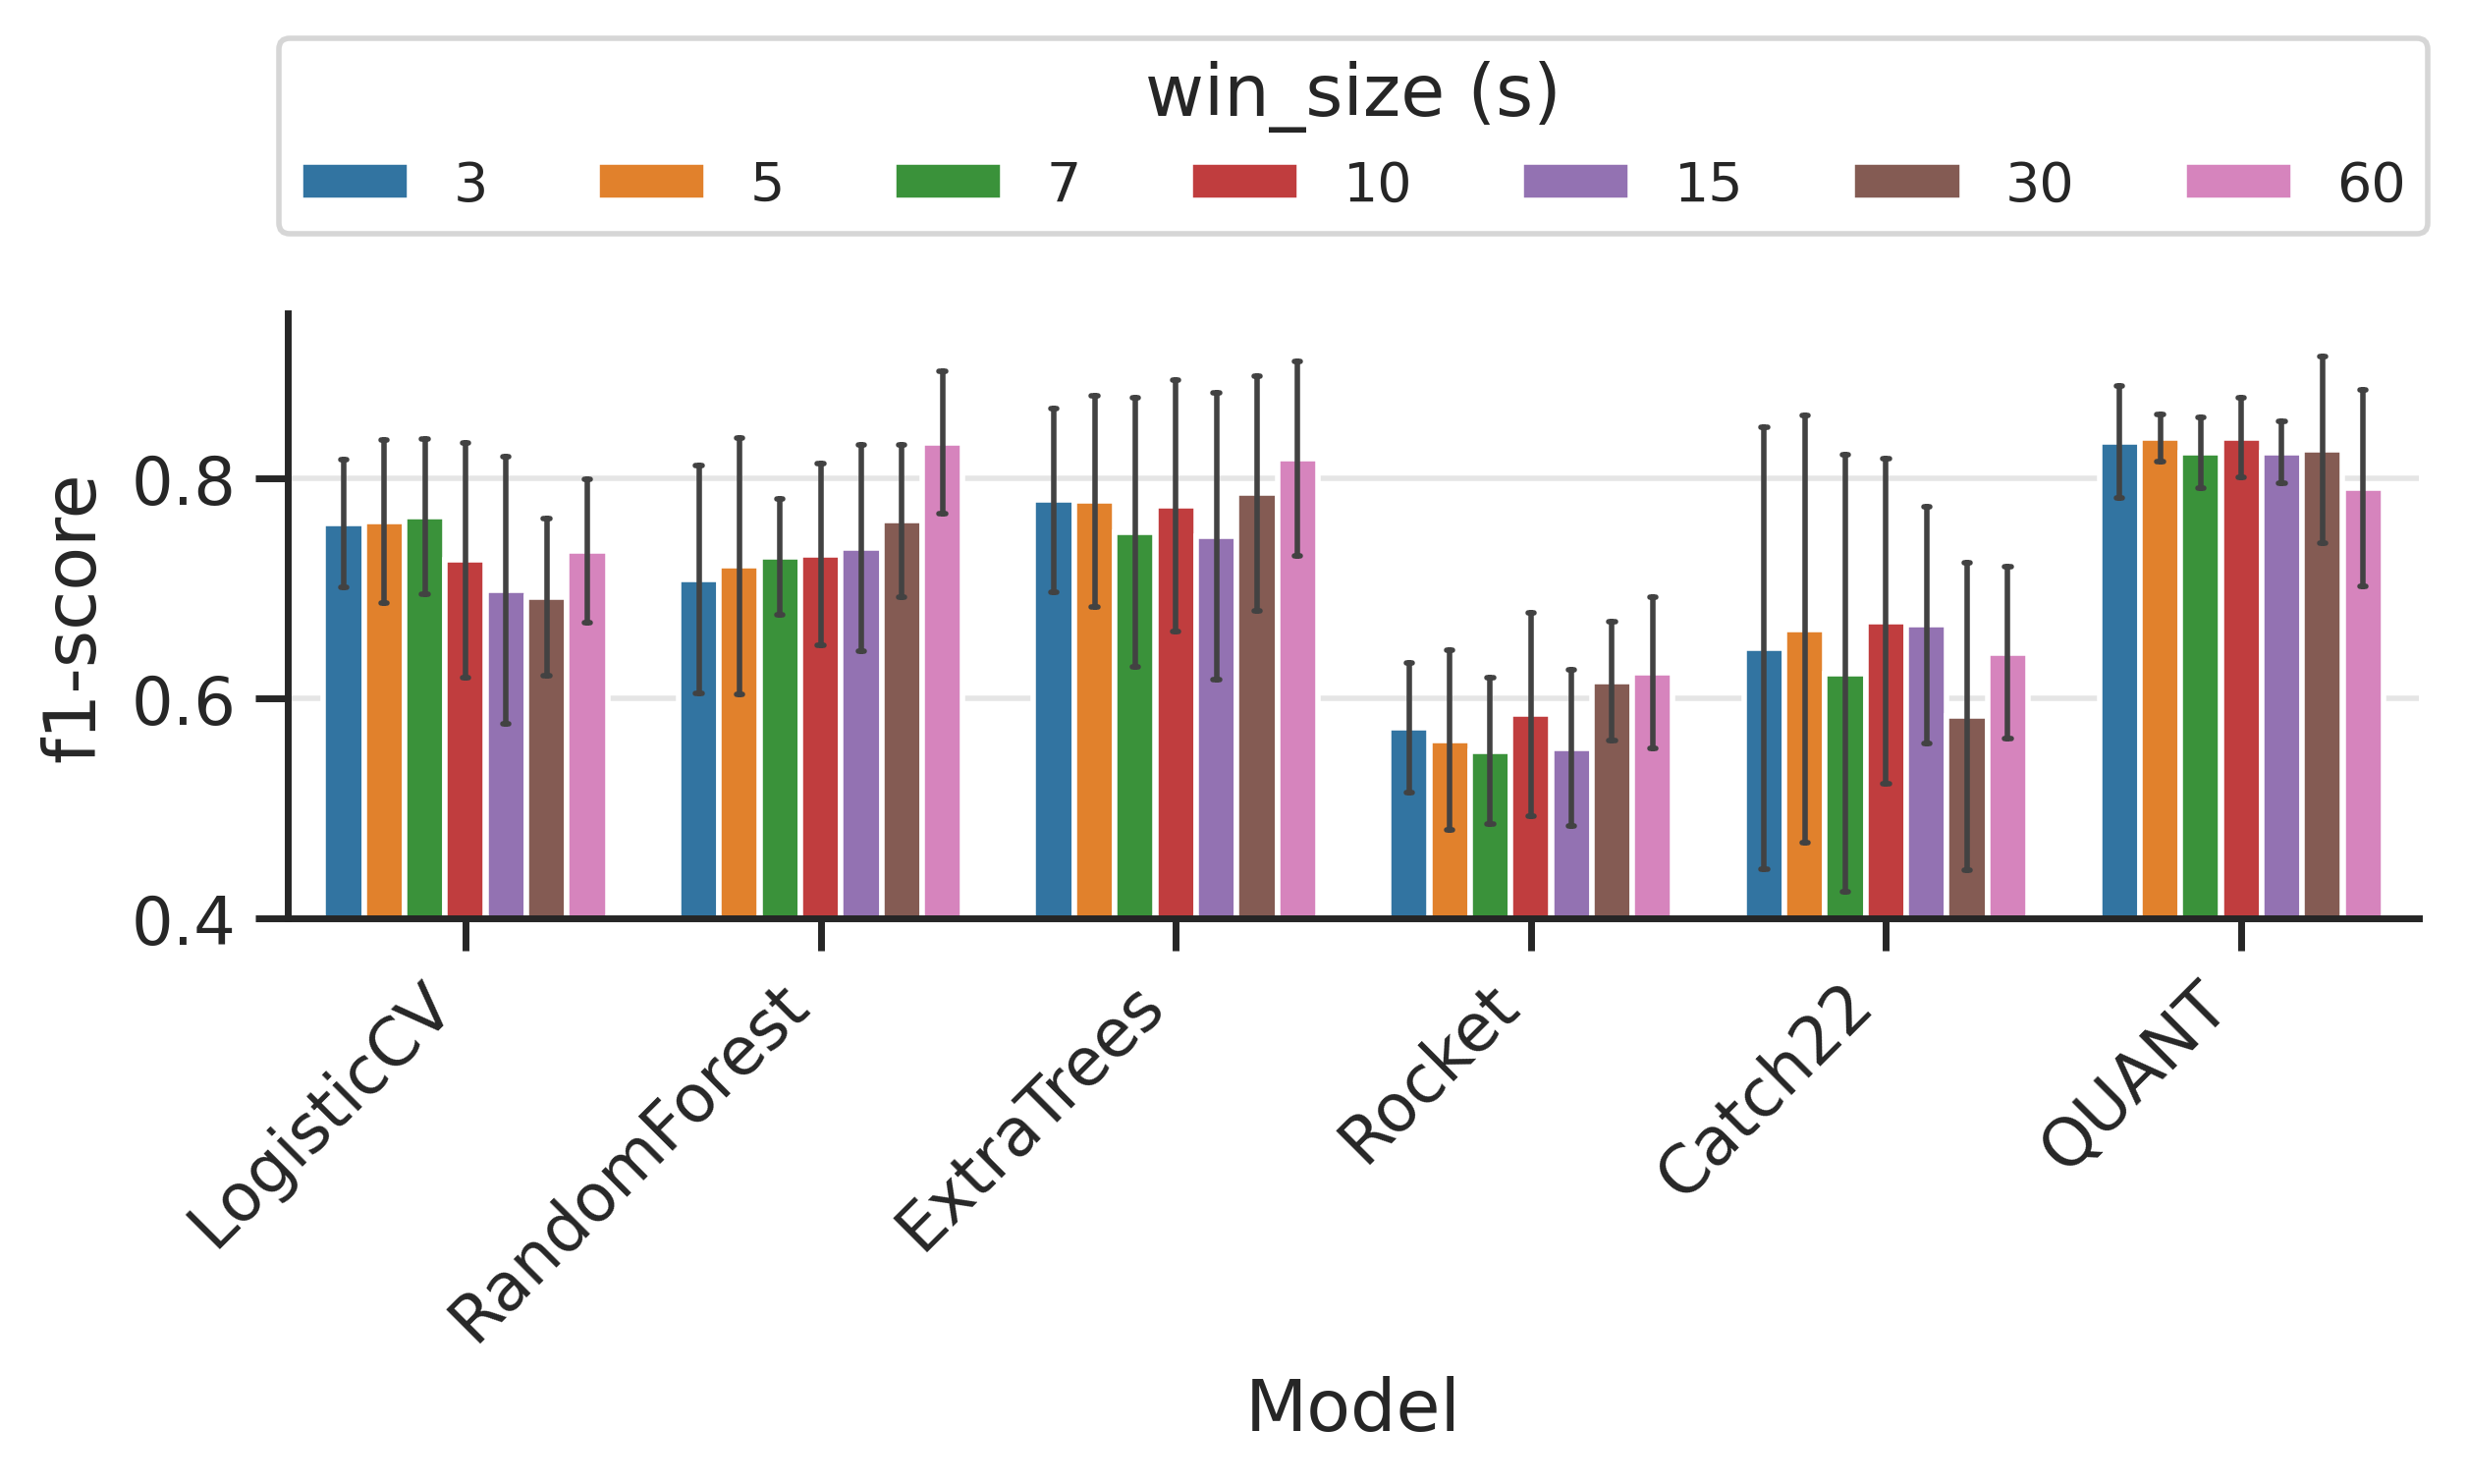

In [7]:
from scripts.plotting import window_bar

plt.figure(figsize=(7, 2), dpi=400)
ax = window_bar(real_cv_metrics.query("seed==0.0"),
                metric="f1-score", ci="sd",
                x="model", hue="window_size")
ax.set_xlabel("Model")
ax.set_title("")
ax.set_ylim(0.4, 0.95)
ax.grid(axis='y', alpha=0.5, which='both')
ax.legend(loc=9, ncol=7, 
          title="win_size (s)",
          bbox_to_anchor=(0.5, 1.5),
          fontsize=10)
ax.set_title("")
plt.savefig(FIG_DIR / "window_bar.pdf", bbox_inches='tight')
plt.show()

In [7]:
# drop ensemble rows
cv_metrics_no_ensenmble = real_cv_metrics.query("seed == 0.0")
grps = cv_metrics_no_ensenmble.groupby(['model', 'window_size']).mean(numeric_only=True)
# pick best model and window size
best_model = grps['f1-score'].idxmax()[0]
best_window = grps['f1-score'].idxmax()[1]
print(f"Best model: {best_model} with window size of {best_window} seconds")

Best model: QUANT with window size of 10 seconds


In [9]:
cv_metrics_no_ensenmble

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,fold
0,LogisticCV,0.0,3,0.205031,4.454545,0.842105,0.727273,0.999999,0.780488,0.863636,0.409088,0.818175,0.001,1
1,RandomForest,0.0,3,0.198551,0.045455,0.800000,0.909091,0.999998,0.851064,0.954545,0.681813,0.272725,0.001,1
2,ExtraTrees,0.0,3,0.200628,0.909091,0.909091,0.909091,0.999999,0.909091,0.954545,0.272725,0.272725,0.001,1
3,Rocket,0.0,3,4.023338,0.545455,0.333333,0.818182,0.999986,0.473684,0.909084,4.909050,0.545450,0.001,1
4,Catch22,0.0,3,6.329436,0.772727,0.714286,0.909091,0.999997,0.800000,0.954544,1.090900,0.272725,0.001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,RandomForest,0.0,60,0.501969,-7.201081,0.750000,0.810811,0.999998,0.779221,0.905404,0.815173,0.570621,0.001,5
308,ExtraTrees,0.0,60,0.489665,-5.263784,0.837838,0.837838,0.999999,0.837838,0.918918,0.489104,0.489104,0.001,5
309,Rocket,0.0,60,57.233424,-27.113243,0.483871,0.810811,0.999993,0.606061,0.905402,2.608554,0.570621,0.001,5
310,Catch22,0.0,60,123.774112,-29.194324,0.417910,0.756757,0.999991,0.538462,0.878374,3.179175,0.733656,0.001,5


In [10]:
# use multiple comparison matrix from aeon
from aeon.visualisation import create_multi_comparison_matrix

pivots = cv_metrics_no_ensenmble.pivot_table(
    index='fold',
    columns='model',
	values='f1-score',
    aggfunc='mean'
)
pivots

model,Catch22,ExtraTrees,LogisticCV,QUANT,RandomForest,Rocket
fold,,,,,,
1,0.683856,0.934002,0.791777,0.854347,0.834682,0.492852
2,0.771202,0.815350,0.800376,0.866292,0.797511,0.576047
3,0.455554,0.698955,0.685119,0.798997,0.693376,0.637290
4,0.738308,0.693970,0.770282,0.832795,0.719503,0.637701
5,0.561880,0.742415,0.621768,0.770772,0.683981,0.562416


In [12]:
create_multi_comparison_matrix(pivots,
                               used_statistic='F1-score',
                            #    win_label='wins',
                            #    loss_label='losses',
                            #    tie_label='ties',
                               font_size=19,
                               fig_size="20,10",
                               pdf_savename=FIG_DIR / "multi_comparison_matrix.pdf")
plt.show()

### Cost Sensitive Threshold Tuning

In [13]:
best_windows = json.load(open(RES_DIR/"best_window.json", "r"))
win_sizes = set([best_windows[m.name] for m in MODEL_SPECS\
                  if m.kind != "baseline" and "Ensemble" not in m.name])
# create datasets for each window size
whole_df = fs.load()
datasets = {}
for win in win_sizes:
    datasets[win] = utils.split_df(
		whole_df, fs, test_set=TEST_SUBJ,
        window_size=win, segment_test=False,
        thresh=1.4, multiphase=True
	)

KeyError: 'ResNet'

In [10]:
from scripts.model_runner import run_models

thresh_metrics = []
baselines = get_model_specs(kind="baseline")
for t in [False, True]:
	for win in win_sizes:
		print(f"Running models for window size {win} seconds, thresh={t}")
		# Select models for this window size
		models = [m for m in MODEL_SPECS
			 if m.kind != "baseline"
				  and best_windows[m.name] == win]
		if not t and models != []:
			models += baselines
		print(f"Selected models: {[m.name for m in models]}")
		X_tr, X_te, y_tr, y_te = datasets[win]
		res = run_models(
			X_tr, X_te, y_tr, y_te,
			model_specs=models,
			model_seeds=SEEDS,
			verbose=True,
			ensemble_models=False,
			ensemble_by_kind=False,
			window_size=win,
			tune_threshold=t
		)
		res["window_size"] = win
		thresh_metrics.append(res)
thresh_df = pd.concat(thresh_metrics, ignore_index=True)
thresh_df.to_csv(RES_DIR / "thresh_metrics.csv", index=False)

Running models for window size 10 seconds, thresh=False
Selected models: ['Catch22', 'QUANT', 'DummyADL', 'DummyFall']
TRAINING (seed=0) Catch22. QUANT. ✅
TRAINING (seed=1) Catch22. QUANT. ✅
TRAINING (seed=2) Catch22. QUANT. ✅
TESTING Catch22_0. QUANT_0. DummyADL_0. DummyFall_0. Catch22_1. QUANT_1. Catch22_2. QUANT_2. ✅
Running models for window size 60 seconds, thresh=False
Selected models: ['RandomForest', 'ExtraTrees', 'Rocket', 'DummyADL', 'DummyFall']
TRAINING (seed=0) RandomForest. ExtraTrees. Rocket. ✅
TRAINING (seed=1) RandomForest. ExtraTrees. Rocket. ✅
TRAINING (seed=2) RandomForest. ExtraTrees. Rocket. ✅
TESTING RandomForest_0. ExtraTrees_0. Rocket_0. DummyADL_0. DummyFall_0. RandomForest_1. ExtraTrees_1. Rocket_1. RandomForest_2. ExtraTrees_2. Rocket_2. ✅
Running models for window size 7 seconds, thresh=False
Selected models: ['LogisticCV', 'DummyADL', 'DummyFall']
TRAINING (seed=0) LogisticCV. ✅
TRAINING (seed=1) LogisticCV. ✅
TRAINING (seed=2) LogisticCV. ✅
TESTING Logist

In [8]:
get_model_specs()

[ModelSpec(name='DummyADL', estimator=DummyClassifier(random_state=0, strategy='most_frequent'), kind='baseline'),
 ModelSpec(name='DummyFall', estimator=DummyClassifier(constant=1, random_state=0, strategy='constant'), kind='baseline'),
 ModelSpec(name='ExtraTrees', estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('simpleimputer', SimpleImputer()),
                 ('extratreesclassifier',
                  ExtraTreesClassifier(criterion='entropy', max_features=0.1,
                                       n_estimators=150, random_state=0))]), kind='tabular'),
 ModelSpec(name='MRocket', estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('simpleimputer', SimpleImputer()),
                 ('minirocketclassifier',
                  MiniRocketClassifier(n_jobs=-1, random_state=0))]), kind='ts'),
 ModelSpec(name='Catch22', estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('simpleimputer', SimpleI

In [9]:
dataset = utils.split_df(
		fs.load(), fs, test_set=TEST_SUBJ,
        window_size=10, segment_test=False,
        thresh=1.4, multiphase=True
	)

Train set: 124 samples, Test set: 21 samples
Train set: X: (1213, 1000), y: (1213,)    ([ADLs, Falls]) [1089  124]
Test set: X: 21, y: 21


In [21]:
from scripts.model_runner import run_models

thresh_metrics = []
baselines = get_model_specs(kind="baseline")
for t in [False, True]:
	print(f"Threshold tuning: {t}")
	for win in [10]:
		X_tr, X_te, y_tr, y_te = dataset
		res = run_models(
			X_tr, X_te, y_tr, y_te,
			model_specs=get_model_specs(subset=['ResNet']),
			verbose=True,
			ensemble_models=False,
			ensemble_by_kind=False,
			window_size=win,
			tune_threshold=t
		)
		res["window_size"] = win
		thresh_metrics.append(res)
thresh_df = pd.concat(thresh_metrics, ignore_index=True)
# thresh_df.to_csv(RES_DIR / "c22_thresh_metrics.csv", index=False)

Threshold tuning: False
TRAINING (seed=0) ResNet. ✅
19/19 [==============================] - 0s 3ms/step
✅
Threshold tuning: True
TRAINING (seed=0) ResNet. 

ValueError: You called `set_weights(weights)` on layer "f1_score" with a weight list of length 4, but the layer was expecting 0 weights. Provided weights: [array([1084.,  113.], dtype=float32), array([11.,...

In [20]:
thresh_df = pd.concat(thresh_metrics, ignore_index=True)
thresh_df

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,ResNet,0,10,1.08085,-10.059048,0.600000,0.857143,0.999995,0.705882,0.928569,1.723102,0.430776,2.321210,0.5
1,LITE,0,10,4.17035,-4.009524,0.472222,0.809524,0.999992,0.596491,0.904758,2.728245,0.574367,2.321196,0.5


In [19]:
# thresh_df = pd.read_csv(RES_DIR / "thresh_metrics.csv")
thresh_df.sort_values(by=["model", "seed", "thresh"])

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
3,Rocket,0,10,0.713429,0.083810,0.695652,0.761905,0.999997,0.727273,0.880951,1.005143,0.717959,2.321208,0.010101
0,Rocket,0,10,0.712934,0.083810,0.695652,0.761905,0.999997,0.727273,0.880951,1.005143,0.717959,2.321208,0.500000
4,Rocket,1,10,0.712552,-1.106667,0.653846,0.809524,0.999996,0.723404,0.904760,1.292327,0.574367,2.321210,0.010101
1,Rocket,1,10,0.701368,-1.106667,0.653846,0.809524,0.999996,0.723404,0.904760,1.292327,0.574367,2.321210,0.500000
5,Rocket,2,10,0.712101,1.179048,0.714286,0.714286,0.999998,0.714286,0.857142,0.861551,0.861551,2.321206,0.010101
2,Rocket,2,10,0.705834,1.179048,0.714286,0.714286,0.999998,0.714286,0.857142,0.861551,0.861551,2.321206,0.500000


In [12]:
# select where model is dummy
dummy_df = thresh_df.query("model.str.contains('Dummy')", engine='python')
real_thresh_df = thresh_df.query("not model.str.contains('Dummy')", engine='python')
real_thresh_df.sort_values(by=["model", "seed"])

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,Catch22,0,10,38.516723,-4.106667,0.580645,0.857143,0.999995,0.692308,0.928569,1.866694,0.430776,2.321208,0.500000
24,Catch22,0,10,37.964936,-4.487619,0.473684,0.857143,0.999992,0.610169,0.928567,2.871837,0.430776,2.321199,0.378182
4,Catch22,1,10,36.019427,-4.106667,0.600000,0.857143,0.999995,0.705882,0.928569,1.723102,0.430776,2.321210,0.500000
26,Catch22,1,10,35.822125,-6.344762,0.473684,0.857143,0.999992,0.610169,0.928567,2.871837,0.430776,2.321199,0.378182
6,Catch22,2,10,36.950643,-5.106667,0.593750,0.904762,0.999995,0.716981,0.952378,1.866694,0.287184,2.321213,0.500000
28,Catch22,2,10,37.013611,-7.678095,0.513514,0.904762,0.999993,0.655172,0.952377,2.584653,0.287184,2.321206,0.378182
9,ExtraTrees,0,60,0.547923,3.998095,0.941176,0.761905,1.000000,0.842105,0.880952,0.143592,0.717959,2.320244,0.500000
31,ExtraTrees,0,60,0.549080,3.998095,0.941176,0.761905,1.000000,0.842105,0.880952,0.143592,0.717959,2.320244,0.484848
14,ExtraTrees,1,60,0.573748,3.998095,0.888889,0.761905,0.999999,0.820513,0.880952,0.287184,0.717959,2.320243,0.500000
34,ExtraTrees,1,60,0.560597,3.998095,0.888889,0.761905,0.999999,0.820513,0.880952,0.287184,0.717959,2.320243,0.484848


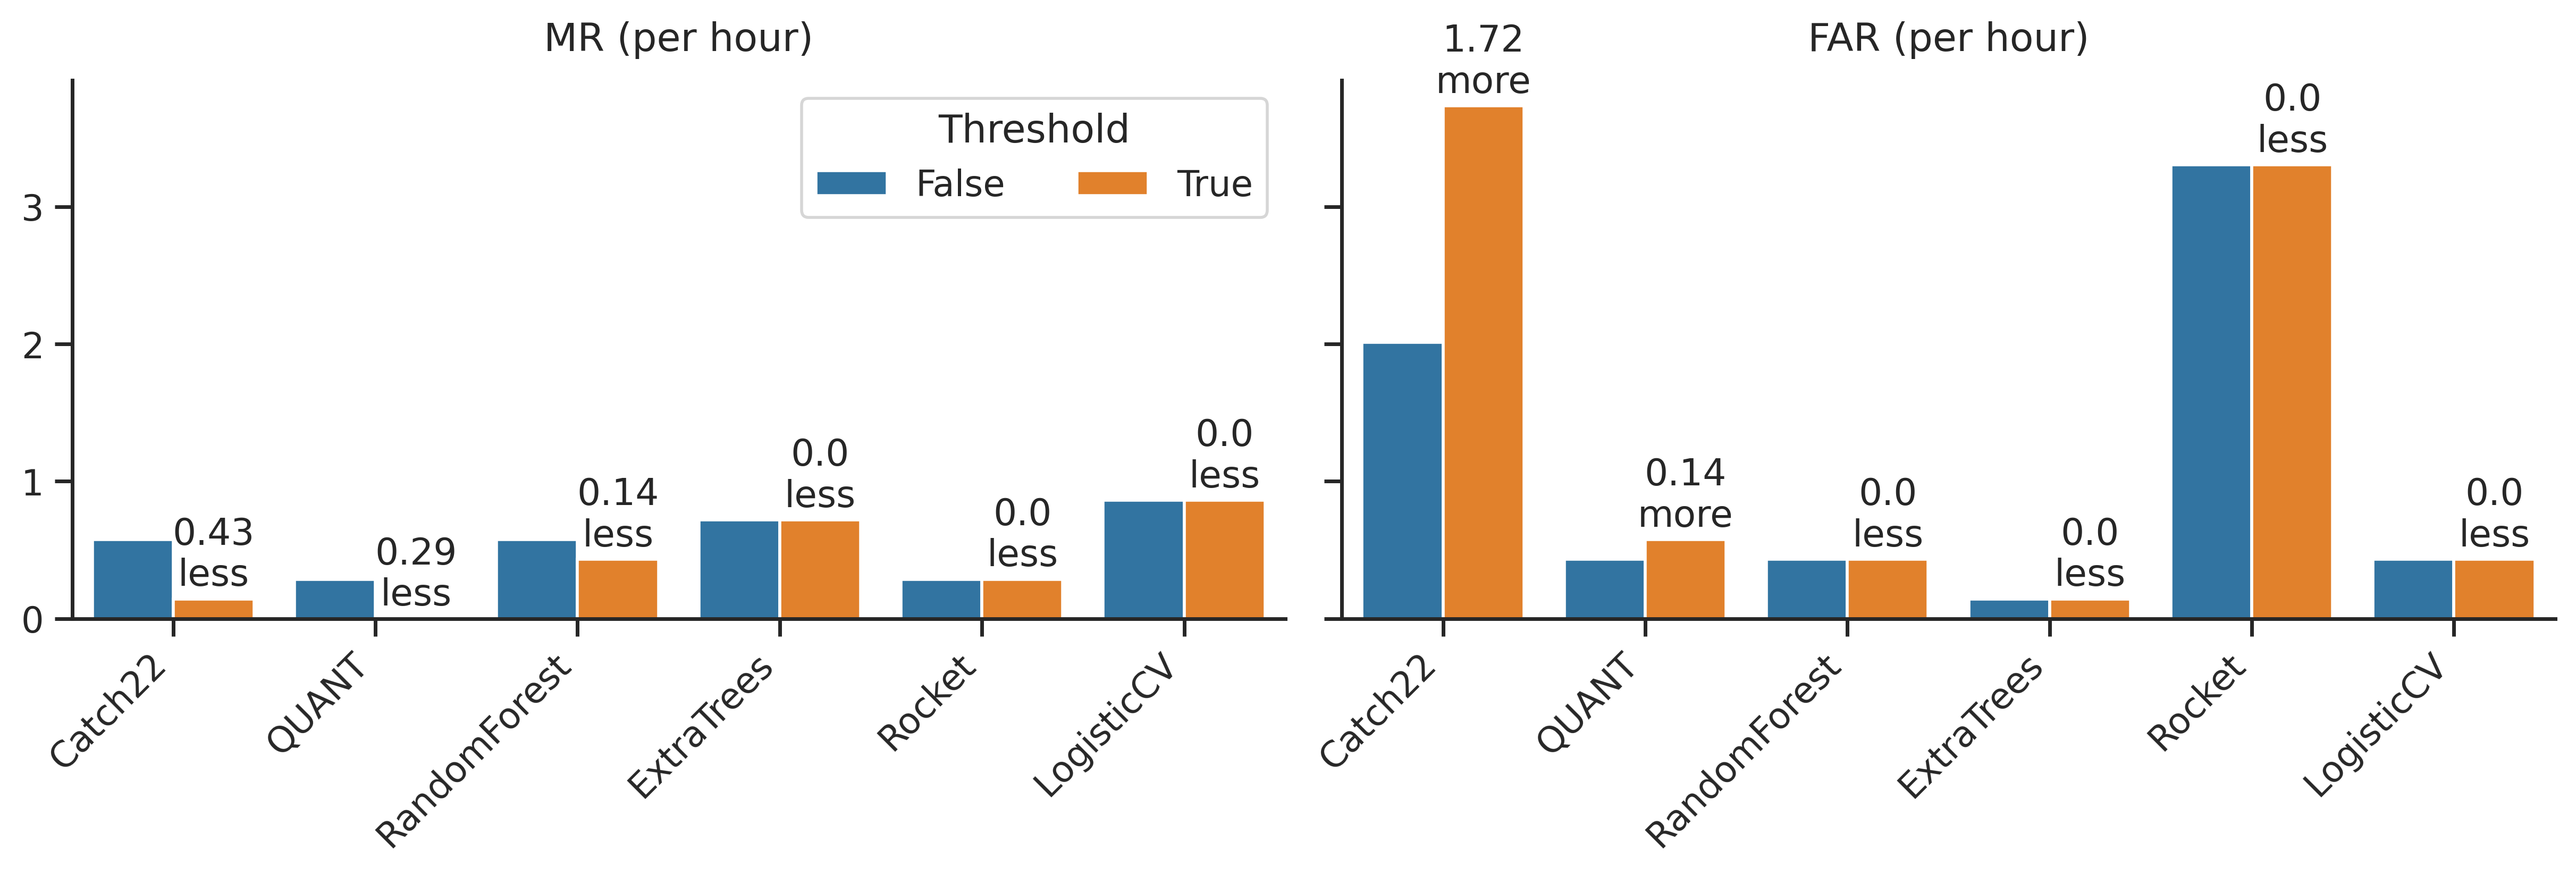

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400,
					   sharey=True, layout='constrained')
for i, m in enumerate(['miss rate', 'false alarm rate']):
	sns.barplot(data=thresh_df, x='model', y=m, hue='tuned',
			 ax=ax[i], palette='tab10')
	labels1 = [x for x in ax[i].containers[0].datavalues] # Round up container[0] values
	labels2 = [x for x in ax[i].containers[1].datavalues] # Round up container[1] values
	improvements = [np.round(b-a,2) for a, b in zip(labels1, labels2)] # Calculate improvements
	lbls = [f'{i}\nmore' if i > 0 else f'{abs(i)}\nless' for i in improvements]
	# Annotate using rounded values
	ax[i].bar_label(ax[i].containers[1], labels=lbls, fontsize=12.5, padding=2)
	ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
	m = 'FAR (per hour)' if m == 'false alarm rate' else m
	m = 'MR (per hour)' if m == 'miss rate' else m
	ax[i].set_title(m, pad=10)
	ax[i].set_xlabel('')
	ax[i].set_ylabel('')
	# only show legend for the last plot
	if i > 0:
		ax[i].get_legend().remove()
	else:
		ax[i].legend(title='Threshold', ncols=2)
sns.despine()
# plt.savefig('figs/barplot_tune_threshold_7sec.pdf',
			# dpi=400, bbox_inches='tight')
plt.show()

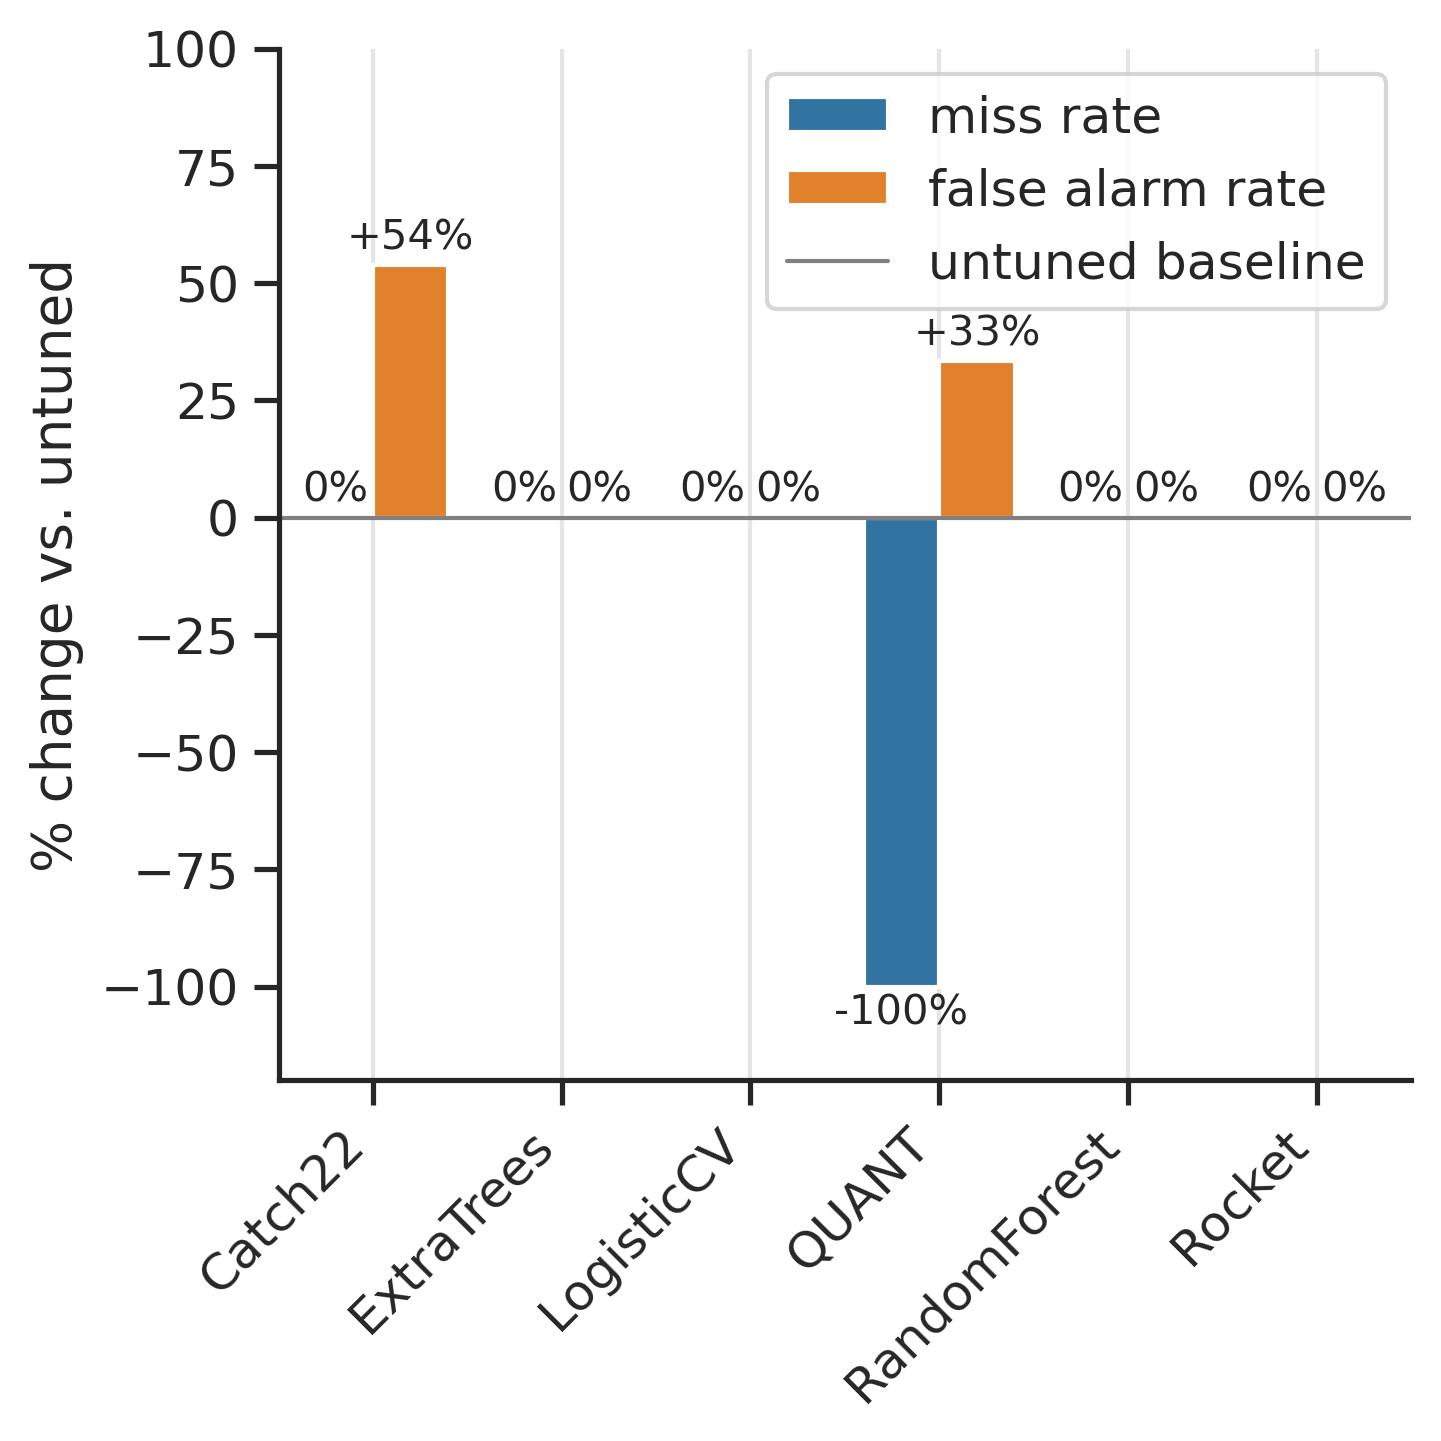

In [13]:
metrics = ["miss rate", "false alarm rate"]

records = []
for model, g in real_thresh_df.groupby("model"):
    # g = g.query("seed==0")
    base = g.query("thresh==0.5")  
    tuned = g.query("thresh!=0.5")
    for m in metrics:
        v0 = base[m].values[0]
        v1 = tuned[m].values[0]
        pct = 100 * (v1 - v0) / v0         # +% worse, −% better
        records.append({"model": model, "metric": m, "pct": pct})
delta_df = pd.DataFrame(records)

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.barplot(data=delta_df, x="model", y="pct", hue="metric",
            palette="tab10", errorbar=None, ax=ax)
# zero-line & label
ax.axhline(0, color="gray", linewidth=1, label="untuned baseline")

# annotate % on every bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        txt = f"{height:+.0f}%"
        if height == 0:
            txt = "0%"
        ax.text(bar.get_x() + bar.get_width()/2,
                height + (1.5 if height>=0 else -1.5),   # small offset
                txt, ha="center", va="bottom" if height>=0 else "top",
                fontsize=10)
ax.set_ylim(-120, 100)  # set y-axis limits
ax.set_ylabel("% change vs. untuned")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend()
ax.grid(axis='x', alpha=0.5, which='both')
sns.despine()
plt.tight_layout()
plt.show()

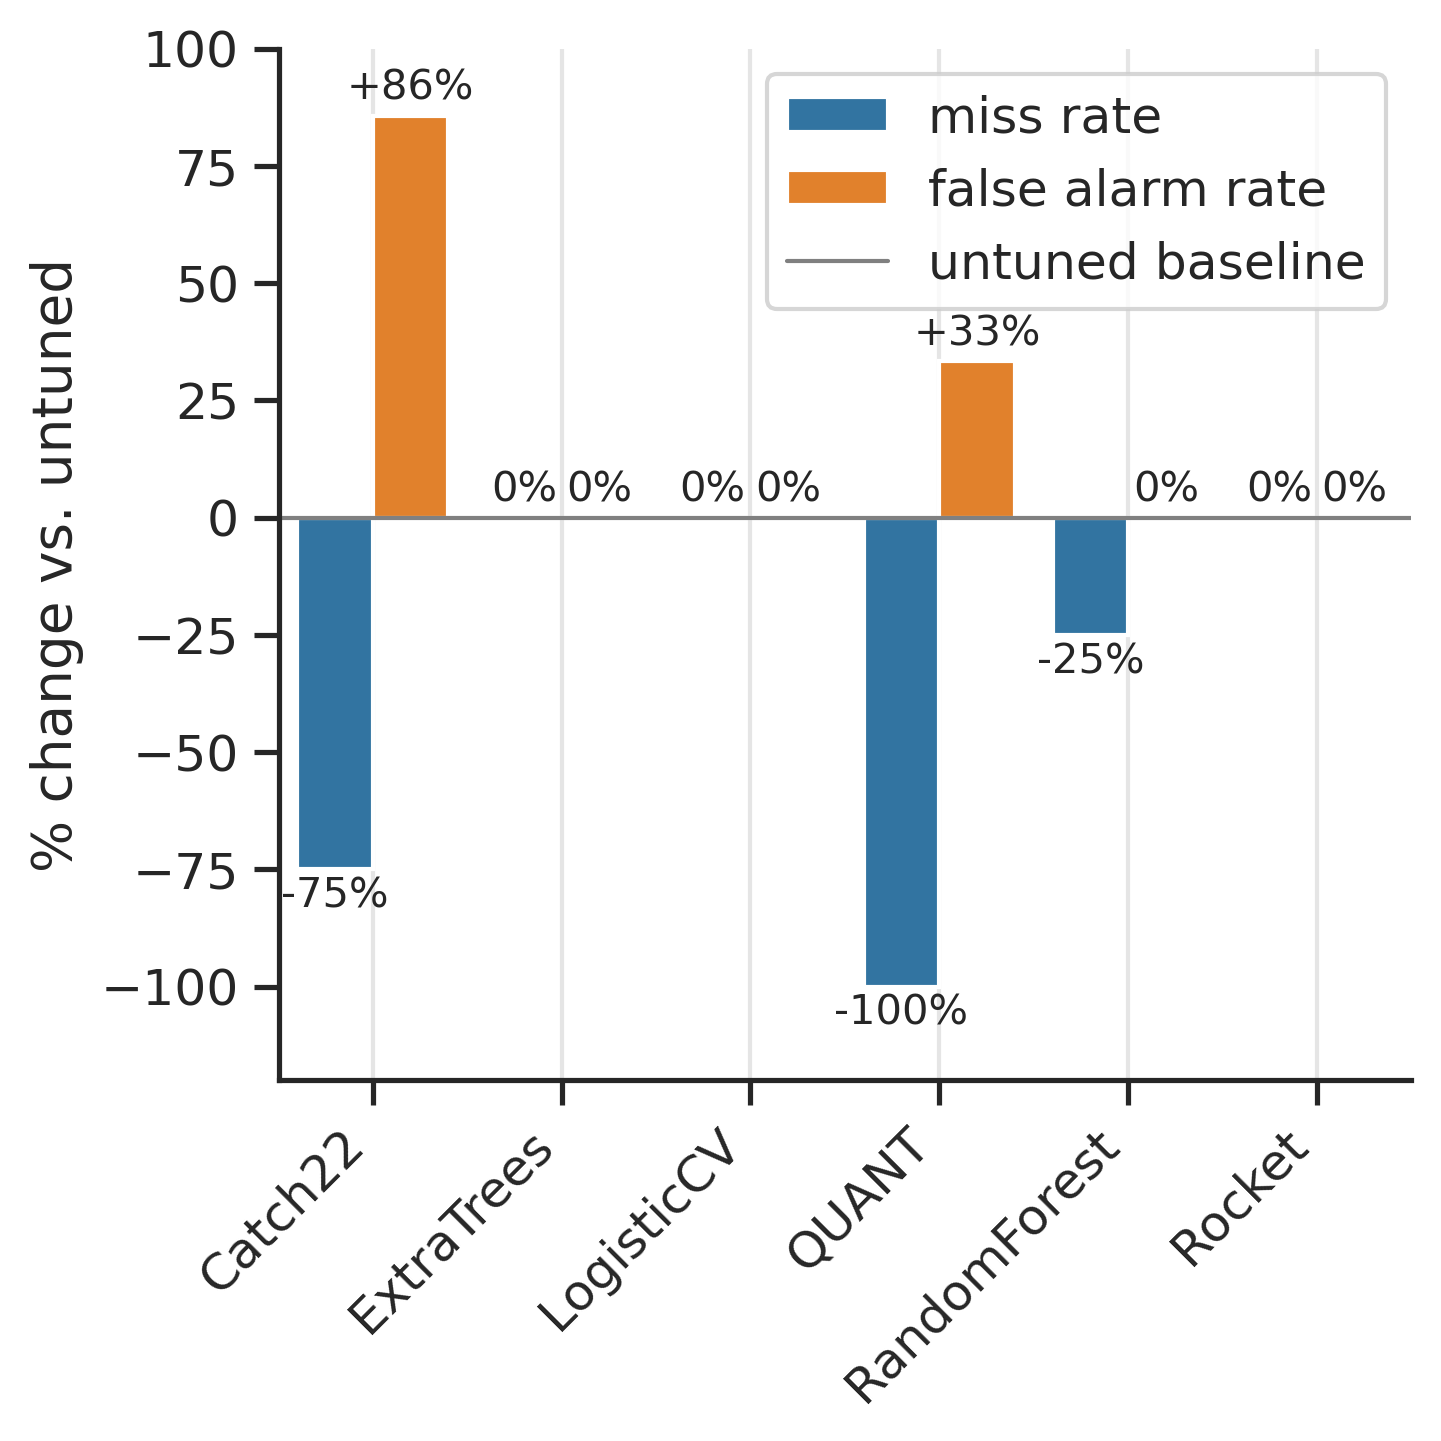

In [45]:
metrics = ["miss rate", "false alarm rate"]

records = []
for model, g in thresh_df.groupby("model"):
    base = g.query("thresh==0.5")  
    tuned = g.query("thresh!=0.5")
    for m in metrics:
        v0 = base[m].values[0]
        v1 = tuned[m].values[0]
        pct = 100 * (v1 - v0) / v0         # +% worse, −% better
        records.append({"model": model, "metric": m, "pct": pct})
delta_df = pd.DataFrame(records)

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.barplot(data=delta_df, x="model", y="pct", hue="metric",
            palette="tab10", errorbar=None, ax=ax)
# zero-line & label
ax.axhline(0, color="gray", linewidth=1, label="untuned baseline")

# annotate % on every bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        txt = f"{height:+.0f}%"
        if height == 0:
            txt = "0%"
        ax.text(bar.get_x() + bar.get_width()/2,
                height + (1.5 if height>=0 else -1.5),   # small offset
                txt, ha="center", va="bottom" if height>=0 else "top",
                fontsize=10)
ax.set_ylim(-120, 100)  # set y-axis limits
ax.set_ylabel("% change vs. untuned")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend()
ax.grid(axis='x', alpha=0.5, which='both')
sns.despine()
plt.tight_layout()
plt.show()